# Setup inicial

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)

import seaborn as sns

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.palettes import Category20c

pd.options.plotting.backend = 'hvplot'
output_notebook()

Loading BokehJS ...

<img src="https://av.sc.com/in/content/images/in-credit-card-banner-1600x490px.jpg" />

# Análisis Exploratorio de Datos sobre solicitudes de tarjeta de crédito

**Fecha de creación: 17/04/2020**

**Autores: Santiago Porchietto, Agustín Trulli**

Este análisis tiene como objetivo realizar una descripción del conjunto de datos encontrado en relación a un histórico de solicitudes de tarjetas de crédito comprendidas entre las fechas dd/mm/yyyy y el dd/mm/yyyy.

<u>Descripción del conjunto de datos</u>:

El presente conjunto de datos posee información referente a clientes del banco que buscan aplicar al otorgamiento de tarjetas de crédito. En funcion de esta información se desea predecir futuros incumplimientos en los pagos para decidir, en base a un treshold de riesgo definido con la institución, la emisión de la tarjeta de crédito para el solicitante.

<u>Las features con las que se cuentan son las siguientes</u>:

* id: número de cliente
* code_gender: sexo
* flag_own_car: si posee auto propio
* flag_own_realty: si posee una propiedad
* cnt_children: cantidad de hijos
* amt_income_total: ingresos anuales
* name_income_type: fuente de ingreso
* name_education_type: nivel de educación
* name_family_status: estado civil
* name_housing_type: tipo de vivienda
* days_birth: dias de diferencia con el nacimiento
* days_employed: fecha de inicio de actividades laborales
* flag_mobil: si cuenta con teléfono móvil
* flag_work_phone: si cuenta con teléfono de trabajo
* flag_phone: si cuenta con telefono fijo
* flag_email: si cuenta con correo electrónico
* occupation_type: ocupación
* cnt_fam_members: tamaño de la familia
* target: Armado manualmente con los criterios que se mencionarán posteriormente

<u>Preguntas</u>:

* ¿Existe alguna relación entre el sexo y la posibilidad de recaer en un incumplimiento de pago de las tarjetas de credito?

* ¿Hay un aumento en el incumplimiento de los pagos de aquellas personas que no poseen auto?

* ¿Hay un aumento en el incumplimiento de los pagos de aquellas personas que no poseen una propiedad?

* ¿Aumenta la probabilidad de incumplimiento del pago con respecto a la cantidad de hijos?

* ¿Los ingresos anuales guardan relación con la probabilidad de no pagar?

* ¿Existe una relación entre la fuente de ingresos y la probabilidad de no pagar?

* ¿Varia la probabilidad de no pagar con respecto a la educación que posee la persona?

* ¿Influye el estado civil en la probabilidad de pago?

* ¿Existe relación entre el tipo de vivienda y la probabilidad de pago?

* ¿Hay edades para las que se registren una mayor cantidad de incumplimientos de pago?

* ¿Cual es la distribución de la cantidad de dias como empleado y que relación guarda con nuestro target?

* ¿Influye tener un telefono laboral en la probabilidad de pago?

* ¿Influye tener un correo electronico en la probabilidad de pago?

* ¿Influye tener un telefono fijo en la probabilidad de pago?

* ¿Hay ocupaciones que presenten una probabilidad de pago menor?

* ¿Guarda relación el tamaño de la familia con respecto a la probabilidad de pago?

In [2]:
#from src.creditapp.data.raw_data_access import get_application_record, get_credit_record

In [3]:
# df_1 = get_application_record()

### Preprocessing

In [4]:
df_clients = pd.read_csv(r"data/raw/application_record.csv", sep=',', encoding='utf-8')
df_account_status = pd.read_csv(r"data/raw/credit_record.csv", sep=',', encoding='utf-8')

In [5]:
# Limpieza del dataset
df_clients.columns = df_clients.columns.str.lower()
# df_clients.drop('flag_phone', axis=1, inplace=True)
df_clients.drop_duplicates(subset='id', keep='first', inplace=True)

# Calculo de la edad en base a la diferencia de dias con el nacimineto
df_clients.days_birth = abs(df_clients.days_birth)
df_clients.loc[::, 'age'] = df_clients.days_birth // 365

df_clients.drop('days_birth', axis=1, inplace=True)

In [6]:
# Para el armado del target se toma el criterio (preguntar si no es claro):
#      1. Se iguala a 0 aquellos resúmenes de cuenta con C o X en su status (no debe)
#      2. De esta forma nos queda una escala del 0 al 6 en el status de la cuenta (donde 0 es "no debe", el resto "debe")
#      3. Se saca la media de estos "status" de cuenta.
#      4. Mergeo de los datasets.
#      5. Debido a la detección de filas duplicadas, se decide sacar la "media de medias" de los status de cuenta.

df_account_status.columns = df_account_status.columns.str.lower()
df_account_status.drop('months_balance', axis=1, inplace=True)

mask = (df_account_status.status == 'X') | (df_account_status.status == 'C')

df_account_status.loc[mask, 'status'] = '-1'
df_account_status['status'] = df_account_status['status'].astype('int64')

df_account_status.loc[::, 'status'] = df_account_status.status + 1  

In [7]:
df_grouped = df_account_status.groupby(['id']).mean()
df_grouped.reset_index(inplace=True)

In [8]:
df_merged = df_clients.merge(df_grouped, left_on='id', right_on='id', how='inner')

In [9]:
df_aux = df_merged.copy()

df_aux.drop('id', axis=1, inplace=True)

cols = ['code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total', 'name_income_type', 
        'name_education_type', 'name_family_status', 'name_housing_type', 'days_employed', 'flag_mobil', 'flag_work_phone', 
        'flag_email', 'cnt_fam_members', 'age']

df_grouped = df_aux.groupby(cols).status.mean()
df_grouped = df_grouped.to_frame()

In [10]:
df_merged.set_index(cols, inplace=True)
df_merged['status_avg'] = df_grouped['status']
df_merged.reset_index(inplace=True)

In [11]:
# Fabricación manual del target, tomando como criterio una "media de medias" mayor o igual a 1

df_merged.drop_duplicates(subset=cols, keep='first', inplace=True)
df_merged.drop('status', axis=1, inplace=True)

df_clients = df_merged.copy()

mask = df_clients.status_avg >= 1

df_clients.loc[::, 'target'] = 0
df_clients.loc[mask, 'target'] = 1

df_clients.drop('status_avg', axis=1, inplace=True)

# EDA

## Análisis previo

In [12]:
print(f'El dataset cuenta con {df_clients.shape[0]} filas y {df_clients.shape[1]} columnas.')

El dataset cuenta con 9458 filas y 19 columnas.


### Tipos de datos de las columnas

In [13]:
df_clients.dtypes.to_frame().reset_index().rename(columns={
    'index': 'columna',
    0: 'type'
}).set_index('columna')

,type
columna,
code_gender,object
flag_own_car,object
flag_own_realty,object
cnt_children,int64
amt_income_total,float64
name_income_type,object
name_education_type,object
name_family_status,object
name_housing_type,object


### Cantidad de nulos por columna

In [14]:
df_clients.isnull().sum().to_frame().reset_index().rename(columns={
    'index': 'columnas',
    0: 'cnt_nulos'
}).set_index('columnas').sort_values('cnt_nulos', ascending=False)

,cnt_nulos
columnas,
occupation_type,2731
code_gender,0
flag_mobil,0
flag_phone,0
id,0
age,0
cnt_fam_members,0
flag_email,0
flag_work_phone,0


In [15]:
mask = df_clients.occupation_type.isnull()

avg = round((len(df_clients[mask]) / len(df_clients)) * 100, 2) 

print('La columna de ocupaciones es la unica que posee valores nulos.')
print(f'Este valor representa el {avg}% del conjunto de datos.')

La columna de ocupaciones es la unica que posee valores nulos.
Este valor representa el 28.88% del conjunto de datos.


### Estadísticos generales

In [16]:
df_clients.describe().round(2)

,cnt_children,amt_income_total,days_employed,flag_mobil,flag_work_phone,flag_email,cnt_fam_members,age,id,flag_phone,target
count,9458.00,9458.00,9458.00,9458.0,9458.00,9458.00,9458.00,9458.00,9458.00,9458.00,9458.00
mean,0.44,182740.55,53055.46,1.0,0.22,0.09,2.19,42.83,5075743.97,0.29,0.10
std,0.77,100105.78,131729.00,0.0,0.42,0.29,0.94,11.44,40853.82,0.45,0.29
min,0.00,27000.00,-15713.00,1.0,0.00,0.00,1.00,20.00,5008804.00,0.00,0.00
25%,0.00,112500.00,-3040.50,1.0,0.00,0.00,2.00,33.00,5036853.50,0.00,0.00
50%,0.00,157500.00,-1436.00,1.0,0.00,0.00,2.00,42.00,5069250.50,0.00,0.00
75%,1.00,225000.00,-410.00,1.0,0.00,0.00,3.00,52.00,5112962.75,1.00,0.00
max,19.00,1575000.00,365243.00,1.0,1.00,1.00,20.00,68.00,5150479.00,1.00,1.00


* La mayor parte de los registros no posee hijos.
* Todas las personas en el dataset son mayores de edad.
* Todos los clientes tienen telefono celular.
* Pocos poseen telefono laboral.
* Pocos poseen una dirección de email.

### Correlación lineal entre las variables

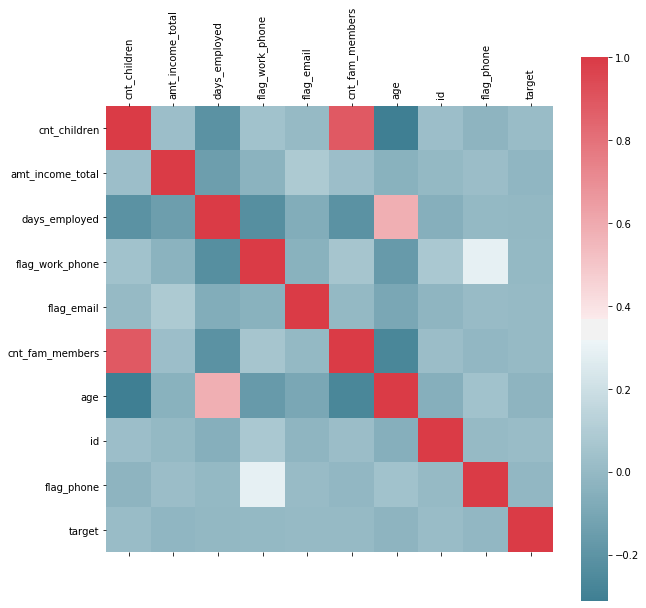

In [17]:
def plot_corr(df, size=10):
    df.drop('flag_mobil', axis=1, inplace=True)
    
    correlation = df.corr()
    
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(correlation)
    
    return sns.heatmap(correlation, mask=np.zeros_like(correlation, dtype=np.bool), 
                       cmap=sns.diverging_palette(220, 10, as_cmap=True),
                       square=True, ax=ax)
    
plot_corr(df_clients)

No se evidencian relaciones lineales evidentes en el set de datos.

## Utils

In [33]:
def make_value_counts(df_clients, feature):
    vc = df_clients[feature].value_counts().to_frame().reset_index().rename(columns={
    'index': feature,
    feature: 'cantidad'
    })

    tot = len(df_clients)

    vc['%_sobre_total'] = round((vc.cantidad / tot) * 100, 2)
    vc.set_index(feature, inplace=True)
    
    return vc

In [36]:
def make_bar_plot(df_clients, feature, title, width, height, invert):
    piv = df_clients.pivot_table('target', feature)

    return piv.plot.bar(title=title, height=height, 
                        width=width, invert=invert, ylim=(0,1))

## Análisis del género

### Distribución del conjunto de datos

In [34]:
make_value_counts(df_clients, 'code_gender')

,cantidad,%_sobre_total
code_gender,,
F,6081,64.29
M,3377,35.71


### Análisis de incumplimiento de pago

In [39]:
make_bar_plot(df_clients, feature='code_gender', title='% de incumplimiento de pago en función del genero',
              width=600, height=300, invert=True)

:Bars   [code_gender]   (target)

No parece haber una relación directa evidente entre la probabilidad de no pagar y el sexo de la persona.

## Análisis de posesión de vehiculos

### Distribución del conjunto de datos

In [35]:
make_value_counts(df_clients, 'flag_own_car')

,cantidad,%_sobre_total
flag_own_car,,
N,5905,62.43
Y,3553,37.57


In [40]:
make_bar_plot(df_clients, feature='flag_own_car', 
              title='% de incumplimiento de pago en función de la posesión de un vehiculo',
              width=600, height=300, invert=True)

:Bars   [flag_own_car]   (target)

No parece haber una relación directa evidente entre la probabilidad de no pagar y el tener un vehiculo propio.

## Análisis de posesión de propiedad

### Distribución del conjunto de datos

In [41]:
make_value_counts(df_clients, 'flag_own_realty')

,cantidad,%_sobre_total
flag_own_realty,,
Y,6287,66.47
N,3171,33.53


### Análisis de la probabilidad de pago

In [42]:
make_bar_plot(df_clients, feature='flag_own_realty', 
              title='% de incumplimiento de pago en función de la posesión de una vivienda',
              width=600, height=300, invert=True)

:Bars   [flag_own_realty]   (target)

No parece haber una relación directa evidente entre la probabilidad de no pagar y el tener una vivienda propia.

## Análisis de la cantidad de hijos

### Distribución del conjunto de datos

In [45]:
make_value_counts(df_clients, 'cnt_children')

,cantidad,%_sobre_total
cnt_children,,
0,6562,69.38
1,1889,19.97
2,854,9.03
3,127,1.34
4,18,0.19
5,5,0.05
7,1,0.01
14,1,0.01
19,1,0.01


### Análisis de la probabilidad de pago en función de si posee hijos

In [69]:
mask = df_clients.cnt_children > 0

df_clients.loc[::, 'have_children'] = 'No'
df_clients.loc[mask, 'have_children'] = 'Yes'

make_bar_plot(df_clients, feature='have_children', 
              title='% de incumplimiento de pago en función de la posesión de hijos',
              width=600, height=300, invert=True)

:Bars   [have_children]   (target)

El poseer hijos no parece ser indicativo de que una persona no vaya a pagar sus deudas.

### Análisis de la probabilidad de pago en función de la cantidad de hijos 

In [63]:
print('Valor que deja el 99.80% de los datos por debajo de la distribución (límite a evaluar): ', 
      df_clients.cnt_children.quantile(0.998))

Valor que deja el 99.80% de los datos por debajo de la distribución (límite a evaluar):  4.0


In [65]:
piv = df_clients[df_clients.cnt_children <= 4].pivot_table('target', 'cnt_children')

piv.plot.line(width=700, height=300, rot=90, ylim=(0,1), 
              title='% de incumplimiento según la cantidad de hijos')

:Curve   [cnt_children]   (target)

No parece haber una relación directa evidente entre la probabilidad de no pagar y la cantidad de hijos que tiene la persona.